In [1]:
# 1

########## 22 April 2021 ##########
######### Alec Hirschauer #########
#
# In this notebook, we will be creating the LAMPTAB file(s)
# for the G130M 1291, 1300, 1309, 1318, and 1321 cenwaves at LP5,
# plus the G140L 800 cenwave at LP3.
#
# Since I am an absolute beginner at working with COS data,
# and eventually someone will have to do this for LP6 as well,
# I'm writing this notebook as clearly as possible to document
# the procedure, making it easier for the next time.
#
# Basically, for each grating/cenwave combination, we need the LAMPTAB
# information in a reference file (per lifetime position [LP])
# which the COS calibration routine (CalCOS) will use to make DISPTAB
# files, which contain dispersion coefficients used to calculate
# wavelength from the pixel number.
#
# From a Pt-Ne lamp, a reference spectrum is observed through the
# Primary Science Aperture (PSA), allowing signal to build up at known
# wavelengths.
#
# A special engineering mode is used to flash the lamp for 30 seconds
# at a time, such that the lamp doesn't get too hot (it's old), and also
# at the beginning of each Visit, there's a single long exposure that allows
# the Optics Select Mechanism (OSM) time to settle.
#
# Finally, for every grating/cenwave, we obtain a spectrum at each of the
# four FP-POS positions, measuring how much pixel shift there is for each
# as compared to FP-POS = 3, which is the baseline position.
#
# Note that for G130M, there are both Segment A and Segment B, while for
# G140L, there is only Segment A.
#
# Before we can work on the data, we'll need to download the data.
#
# I did that separately from this notebook by going to MAST, so I don't
# cover that process here, but it's relatively straightforward.
#
# Just make sure that we're working in the directory that has the data.
#
# Okay, with that, let's get started!


In [2]:
# 2

# The first thing we need to do is import the relevant packages.

import calcos
from astropy.io import fits
import glob
import numpy as np

# Obviously we'll need CalCOS to process the COS data, but also
# astropy's fits to handle the .fits files, glob (which allows for
# manipulating data with similar file names), and numpy to do some
# sorting of the data based on .fits file header information.


In [3]:
# 3

# In my directory with all my data, I want to specify only some files
# to work on, from the vast assortment of files (I downloaded both the
# raw files and the processed files; clearly all we really need here are
# the unprocessed, raw files).
#
# Set a variable called "rawtags" with glob to specify only the files in
# this working directory that have the word "rawtag" in it:

rawtags = glob.glob('*_rawtag_*.fits')


In [4]:
# 4

# From here, we can print out a list of the files set by the command above,

#print(rawtags)

# or print out the whole header of the first file (index[0]),

#fits.getheader(rawtags[0])

# but the next *useful* thing to do is set a consistent 'RANDSEED' value
# for every rawtag file, which will be used for important things later on.

for myfile in rawtags:
    fits.setval(myfile, 'RANDSEED', value=123456789)
    
# This dinky for loop takes all the files defined by "rawtags", then uses
# the astropy fits package to set a value for 'RANDSEED' to the very creative
# value of 123456789.
#
# (Note: "myfile" in this case specifies the very last file set by "rawtags".)


In [5]:
# 5

# We can print out the 'RANDSEED' value to show that the last command did its job,

#fits.getval(myfile, 'RANDSEED')

# but that's only if you really need to prove it to yourself.

# What we need to do now, as stipulated in the ISRs for similar work done, is to
# set the various fits header parameters to what they need to be for when we run
# them through CalCOS, in order for them to run the way we want them to.

for myfile in rawtags:
    fits.setval(myfile, 'FLATCORR', value='OMIT')
    fits.setval(myfile, 'WAVECORR', value='OMIT')
    fits.setval(myfile, 'TRCECORR', value='OMIT')
    fits.setval(myfile, 'ALGNCORR', value='OMIT')
    fits.setval(myfile, 'XTRCTALG', value='BOXCAR')
    fits.setval(myfile, 'X1DCORR', value='PERFORM')
    fits.setval(myfile, 'BACKCORR', value='OMIT')
    fits.setval(myfile, 'FLUXCORR', value='OMIT')
    fits.setval(myfile, 'HELCORR', value='OMIT')
    fits.setval(myfile, 'GEOCORR', value='PERFORM')
    fits.setval(myfile, 'YWLKCORR', value='PERFORM')
    fits.setval(myfile, 'TEMPCORR', value='PERFORM')
    fits.setval(myfile, 'IGEOCORR', value='PERFORM')
    
# Confirm that these parameters are set properly before proceeding!
#
# We are running this all first for the G140L/800 data.


In [6]:
# 6

# Next we need to specify the special lamp flash parameters to match what the
# observations are doing in the APT file, whereby the lamp is on for 30 seconds,
# then off for a while (how long and how many times depends on the exposure),
# so that it builds up signal without getting too hot, which could damage it.
#
# For the science exposures of G130M, the exposure times are 210 seconds, with
# 120 seconds of total lamp on time (four flashes), while for the science exposures
# of G140L, the exposure times are 450 seconds, with 240 seconds of total lamp
# time (eight flashes).
#
# Also note that, for the beginning of each Visit, there's a single long exposure
# to settle the OSM, which is 1440 seconds for the two G130M Visits, but 1800 seconds
# for the single G140L Visit.
#
# We'll set this with a large "if" statement written be Elaine, which sets parameters
# like lamp duration (LMPDUR1), the start time of a flash (LMP_ON1), the end time of
# a flash (LMPOFF1), and the median time of that flash (LMPMED1).
#
# For each kind of exposure, we define this for two flashes, then note the number of
# flashes (NUMFLASH), and how to continue the pattern (set TAGFLASH to 'UNIFORMLY SPACED').
#
# Finally, note at what extension each of these parameters should be set to.

for myfile in rawtags:
    if fits.getval(myfile, 'OPT_ELEM') == 'G130M' and fits.getval(myfile, 'EXPTIME', ext=1) < 220.:
        LMPDUR1 = 30.0
        LMP_ON1 = 0.0
        LMPOFF1 = 30.0
        LMPMED1 = 15.00000
        LMPDUR2 = 30.0
        LMP_ON2 = 60.0
        LMPOFF2 = 90.0
        LMPMED2 = 75.00000
        fits.setval(myfile, 'LMPDUR1', value=LMPDUR1, ext=1)
        fits.setval(myfile, 'LMP_ON1', value=LMP_ON1, ext=1)
        fits.setval(myfile, 'LMPOFF1', value=LMPOFF1, ext=1)
        fits.setval(myfile, 'LMPMED1', value=LMPMED1, ext=1)
        fits.setval(myfile, 'LMPDUR2', value=LMPDUR2, ext=1)
        fits.setval(myfile, 'LMP_ON2', value=LMP_ON2, ext=1)
        fits.setval(myfile, 'LMPOFF2', value=LMPOFF2, ext=1)
        fits.setval(myfile, 'LMPMED2', value=LMPMED2, ext=1)
        fits.setval(myfile, 'NUMFLASH', value=4, ext=1)
        fits.setval(myfile, 'TAGFLASH', value='UNIFORMLY SPACED', ext=0)
    elif fits.getval(myfile, 'OPT_ELEM') == 'G130M' and fits.getval(myfile, 'EXPTIME', ext=1) > 220.:
        LMPDUR1 = 30.0
        LMP_ON1 = 0.0
        LMPOFF1 = 30.0
        LMPMED1 = 15.00000
        LMPDUR2 = 30.0
        LMP_ON2 = 120.0
        LMPOFF2 = 150.0
        LMPMED2 = 135.00000
        fits.setval(myfile, 'LMPDUR1', value=LMPDUR1, ext=1)
        fits.setval(myfile, 'LMP_ON1', value=LMP_ON1, ext=1)
        fits.setval(myfile, 'LMPOFF1', value=LMPOFF1, ext=1)
        fits.setval(myfile, 'LMPMED1', value=LMPMED1, ext=1)
        fits.setval(myfile, 'LMPDUR2', value=LMPDUR2, ext=1)
        fits.setval(myfile, 'LMP_ON2', value=LMP_ON2, ext=1)
        fits.setval(myfile, 'LMPOFF2', value=LMPOFF2, ext=1)
        fits.setval(myfile, 'LMPMED2', value=LMPMED2, ext=1)
        fits.setval(myfile, 'NUMFLASH', value=12, ext=1)
        fits.setval(myfile, 'TAGFLASH', value='UNIFORMLY SPACED', ext=0)
    elif fits.getval(myfile, 'OPT_ELEM') == 'G140L' and fits.getval(myfile, 'EXPTIME', ext=1) < 460.:
        LMPDUR1 = 30.0
        LMP_ON1 = 0.0
        LMPOFF1 = 30.0
        LMPMED1 = 15.00000
        LMPDUR2 = 30.0
        LMP_ON2 = 60.0
        LMPOFF2 = 90.0
        LMPMED2 = 75.00000
        fits.setval(myfile, 'LMPDUR1', value=LMPDUR1, ext=1)
        fits.setval(myfile, 'LMP_ON1', value=LMP_ON1, ext=1)
        fits.setval(myfile, 'LMPOFF1', value=LMPOFF1, ext=1)
        fits.setval(myfile, 'LMPMED1', value=LMPMED1, ext=1)
        fits.setval(myfile, 'LMPDUR2', value=LMPDUR2, ext=1)
        fits.setval(myfile, 'LMP_ON2', value=LMP_ON2, ext=1)
        fits.setval(myfile, 'LMPOFF2', value=LMPOFF2, ext=1)
        fits.setval(myfile, 'LMPMED2', value=LMPMED2, ext=1)
        fits.setval(myfile, 'NUMFLASH', value=8, ext=1)
        fits.setval(myfile, 'TAGFLASH', value='UNIFORMLY SPACED', ext=0)
    elif fits.getval(myfile, 'OPT_ELEM') == 'G140L' and fits.getval(myfile, 'EXPTIME', ext=1) > 460.:
        LMPDUR1 = 30.0
        LMP_ON1 = 0.0
        LMPOFF1 = 30.0
        LMPMED1 = 15.00000
        LMPDUR2 = 30.0
        LMP_ON2 = 120.0
        LMPOFF2 = 150.0
        LMPMED2 = 135.00000
        fits.setval(myfile, 'LMPDUR1', value=LMPDUR1, ext=1)
        fits.setval(myfile, 'LMP_ON1', value=LMP_ON1, ext=1)
        fits.setval(myfile, 'LMPOFF1', value=LMPOFF1, ext=1)
        fits.setval(myfile, 'LMPMED1', value=LMPMED1, ext=1)
        fits.setval(myfile, 'LMPDUR2', value=LMPDUR2, ext=1)
        fits.setval(myfile, 'LMP_ON2', value=LMP_ON2, ext=1)
        fits.setval(myfile, 'LMPOFF2', value=LMPOFF2, ext=1)
        fits.setval(myfile, 'LMPMED2', value=LMPMED2, ext=1)
        fits.setval(myfile, 'NUMFLASH', value=15, ext=1)
        fits.setval(myfile, 'TAGFLASH', value='UNIFORMLY SPACED', ext=0)

# It may not be the most elegant code, but it'll do the job just fine!


In [7]:
# 7

# The next step in the process is to actually run CalCOS on the data.
#
# First, to account for a weird idiosyncrasy whereby CalCOS automatically
# processes rawtag_b files after running on rawtag_a files, then crashes when
# it sees rawtag_b files that have already been processed, let's define
# a new grouping of files that are all the rawtag_a files alone:

rawtagsa = glob.glob('*_rawtag_a.fits')

# Now we can run CalCOS on our data, outputting to a new directory made
# to keep things clean (pick your own directory path):

#for myfile in rawtagsa:
#    calcos.calcos(myfile, outdir='/Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output3')

# Be aware that, if you're running this all locally, this step will take a decent
# amount of time (15-20 minutes, maybe).


In [8]:
# 8

# Output from CalCOS will be used to make the interim LampTab.
#
# NB, since WAVECORR is set to OMIT, the LAMP parameters from Cell #6
# aren't going to be used, but we'll need it later when we run CalCOS again
# later on.
#
# Import the python routines that Elaine sent to me:

from make_interim_lamptab import *
#from common_correlation_tasks import *
from updating_lamptab import *

# Removed the bottom two because they're already called by the first one,
# and we were getting errors like crazy.


In [9]:
# 9

lampdataLP3 = '52j2110ml_lamp.fits'

# ^ This is the file we're updating to make our interim file.
#
# We'll use the x1d file we made in CalCOS and pull out the array of the first flash.
# This is what's put into the intensity array of the lamptab file.
# First flash so it's not blurred by drift.
# Actually we're using the x1d file, which is the combined flashes,
# which if it has any drift this will be blurred around.
# But since it's only the interim file, maybe this doesn't matter so much?
# Also note that, there shouldn't be a lot of drift since we took the
# single long exposure at the beginning of each Visit.

x1ds = glob.glob('/Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output3/*_x1d.fits')

# This globs all the x1ds from the output directory, but now we need to
# isolate the x1ds that were a part of the long OSM-settling exposure(s).
# Also, we want to isolate the G140L/800 exposures as well.

x1ds_c800 = []
for myfile in x1ds:
    if fits.getval(myfile, 'OPT_ELEM') == 'G140L' and fits.getval(myfile, 'EXPTIME', ext=1) < 1000.:
        x1ds_c800.append(myfile)
        
print(len(x1ds_c800))

# ^ This gives us four, which is the number of FP-POS for Segment A.


4


In [10]:
# 10

# Make the interim lamptab...

newlamptab = '22April2021_interim_lamp.fits'

# We'll use one of the functions contained within "updating_lamptab.py".

makelamptemplatefile(newlamptab, lampdataLP3, x1ds_c800)

# This should write out a new file for me.


G140L 800 -1 449.92
G140L 800 0 449.824
G140L 800 1 449.664
G140L 800 -2 449.76


800
480.0 519.0


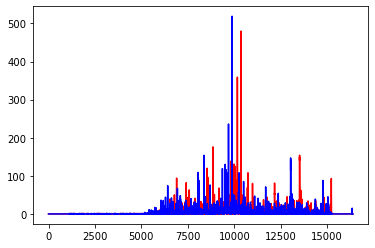

CORRELATING 0 vs -2 Shift: -477.3806152738871
saved interim_FP_shifts_NOdrift.txt
800 FUVB no data to shift
480.0 474.0


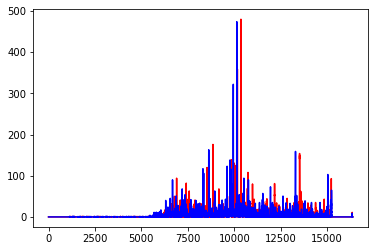

CORRELATING 0 vs -1 Shift: -221.48107241944672
saved interim_FP_shifts_NOdrift.txt
800 FUVB no data to shift
480.0 526.0


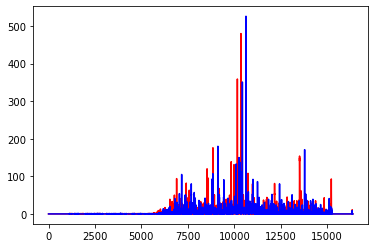

CORRELATING 0 vs 1 Shift: 269.97249706946604
saved interim_FP_shifts_NOdrift.txt
800 FUVB no data to shift
1055
1096
1105
1222
1230
1280
1291
1300
1309
1318
1327
1577
1589
1600
1611
1623
800


800 -2 FUVA -477.3806152738871
800 -1 FUVA -221.48107241944672
800 1 FUVA 269.97249706946604


In [11]:
# 11

# Define a name for a .txt save file.

save_file = 'interim_FP_shifts_NOdrift.txt'
find_fp_pix_shift(newlamptab, save_file)

# This routine is in the "make_interim_lamptab" routine.
# Saves new pixel shifts into .txt file, then we'll update the Lamp Tab file one more time
# to update those positions.

update_lamptab(save_file, newlamptab)


In [12]:
# 12

# What we have above are three lamp tab plots which show in red the FP-POS=3 spectrum,
# and compared with that are the blue spectra of FP-POS=1, 2, & 4.
#
# Also note the values of the pixel shifts.
#
# Now let's compare the old and the new with fits diff.

!fitsdiff 52j2110ml_lamp.fits 22April2021_interim_lamp.fits

# Sanity check that the file was updated properly!



 fitsdiff: 3.1.1
 a: 52j2110ml_lamp.fits
 b: 22April2021_interim_lamp.fits
 Maximum number of different data values to be reported: 10
 Relative tolerance: 0.0, Absolute tolerance: 0.0

Primary HDU:

   Headers contain differences:
     Keyword CHECKSUM has different values:
        a> 9EpJEEmI9EmICEmI
        b> 9HnJFEnJ9EnJCEnJ
     Keyword CHECKSUM has different comments:
        a> HDU checksum updated 2021-02-19T16:10:45
         ?                             ^^^  ^  ^^^^
        b> HDU checksum updated 2021-04-22T11:39:12
         ?                            ++ ^  ^^^^  ^
     Keyword DATASUM  has different comments:
        a> data unit checksum updated 2021-02-19T16:10:45
         ?                                   ^^^  ^  ^^^^
        b> data unit checksum updated 2021-04-22T11:39:12
         ?                                  ++ ^  ^^^^  ^

Extension HDU 1:

   Headers contain differences:
     Keyword CHECKSUM has different values:
        a> ZUjJaRhGTRhGZRhG
        b> J

In [13]:
# 13

# Next up is to run CalCOS again!

# Changing WAVECORR to PERFORM, but everything else is the same
# from when we did this earlier.
# But also at the end, specify the new interim lamp tab file.
# Also, note that we're not changing the extract tab,
# we're using the LP3 extract tab which for cenwave 800
# has the 1105 entries.
# And we're not changing the disptab.
# Currently using LP3 disptab which has the LP4 disptab entries for c800.

for myfile in rawtags:
    fits.setval(myfile, 'FLATCORR', value='OMIT')
    fits.setval(myfile, 'WAVECORR', value='PERFORM')
    fits.setval(myfile, 'TRCECORR', value='OMIT')
    fits.setval(myfile, 'ALGNCORR', value='OMIT')
    fits.setval(myfile, 'XTRCTALG', value='BOXCAR')
    fits.setval(myfile, 'X1DCORR', value='PERFORM')
    fits.setval(myfile, 'BACKCORR', value='OMIT')
    fits.setval(myfile, 'FLUXCORR', value='OMIT')
    fits.setval(myfile, 'HELCORR', value='OMIT')
    fits.setval(myfile, 'GEOCORR', value='PERFORM')
    fits.setval(myfile, 'YWLKCORR', value='PERFORM')
    fits.setval(myfile, 'TEMPCORR', value='PERFORM')
    fits.setval(myfile, 'IGEOCORR', value='PERFORM')
    fits.setval(myfile, 'LAMPTAB', value='22April2021_interim_lamp.fits')

# Because I'm setting the same set of files to calibrate, because I'm setting the
# lamptab here, it changes the default for if/when I try to run this again
# from the start.


In [14]:
# 14

# We're running CalCOS again, so let's make a new directory to put the output.
#
# And here we're just grabbing all the cenwave 800 rawtags (they're only Segment A).

rawtags_c800 = []
for myfile in rawtags:
    if fits.getval(myfile, 'OPT_ELEM') == 'G140L' and fits.getval(myfile, 'EXPTIME', ext=1) < 1000.:
        rawtags_c800.append(myfile)
        
#for myfile in rawtags_c800:
#    calcos.calcos(myfile, outdir='/Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output4')

# ^ Comment out running CalCOS again in case I re-run the cell, since it takes forever.


CALCOS version 3.3.10
numpy version 1.19.2
astropy version 4.2.1
Begin 22-Apr-2021 11:59:52 EDT
Input file = leih03iiq_rawtag_a.fits
    EXPTYPE will be changed to EXTERNAL/CAL.

TIME-TAG calibration -- 22-Apr-2021 11:59:55 EDT
Input     leih03iiq_rawtag_a.fits
OutTag    /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output4/leih03iiq_corrtag_a.fits
OutFlt    /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output4/leih03iiq_flt_a.fits
OutCounts /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output4/leih03iiq_counts_a.fits
OutFlash  /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output4/leih03iiq_lampflash_a.fits
DETECTOR  FUV, segment A
EXPTYPE   EXTERNAL/CAL
OPT_ELEM  G140L, CENWAVE 800, FPOFFSET -2
APERTURE  WCA

BADTCORR  OMIT
RANDCORR  PERFORM
RANDSEED = 123456789
TEMPCORR  PERFORM
BRFTAB  = lref$x1u1459il_brf.fits
GEOCORR   PERFORM
GEOFILE = lref$x1u1459gl_geo.fits
IGEOCORR  PERFORM
DGEOCORR  OMIT
XWLKC

EXPTYPE   EXTERNAL/CAL
OPT_ELEM  G140L, CENWAVE 800, FPOFFSET -1
APERTURE  WCA

BADTCORR  OMIT
RANDCORR  PERFORM
RANDSEED = 123456789
TEMPCORR  PERFORM
BRFTAB  = lref$x1u1459il_brf.fits
GEOCORR   PERFORM
GEOFILE = lref$x1u1459gl_geo.fits
IGEOCORR  PERFORM
DGEOCORR  OMIT
XWLKCORR  PERFORM
XWLKFILE= lref$14o2013ql_xwalk.fits
YWLKCORR  PERFORM
YWLKFILE= lref$14o2013rl_ywalk.fits
DEADCORR  PERFORM
DEADTAB = lref$s7g1700gl_dead.fits
PHACORR   PERFORM
PHATAB  = lref$wc318317l_pha.fits
DOPPCORR  OMIT
FLATCORR  OMIT
WAVECORR  PERFORM
Process tagflash wavecal
WCPTAB  = lref$u1t1616ql_wcp.fits
LAMPTAB = 22April2021_interim_lamp.fits
XTRACTAB= lref$52j2110kl_1dx.fits
DISPTAB = lref$52j2117ml_disp.fits
lamp on, off, duration, median time:
1:  0.7  30.7  30.0  16.0
2:  60.7  90.7  30.0  75.8
3:  121.7  150.7  29.0  136.3
4:  180.7  210.7  30.0  195.7
5:  241.7  270.7  29.0  256.1
6:  300.7  330.7  30.0  315.6
7:  360.7  390.7  30.0  375.8
8:  420.7  450.0  29.3  435.4
  segment    cross-disp       

In [15]:
# 15

# We're now looking at the python routine called
# "removedriftfromwavecorr.py"
# and Elaine is explaining what it does:
#
# First, set up where everything's going to go.

corrdir = '/Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/output4'
outputdir = '/Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/G140L_corrtags_deshifted'
calcosout = '/Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/G140L_x1ds_deshifted'

import os
from removedriftfromwavecorr import *

lffiles = glob.glob(os.path.join(corrdir, '*lampflash.fits'))

# Copy+Paste from Camellia's code:

for lampflash in lffiles:
        
# open the lampflash file and grab the data and header
    with fits.open(lampflash) as df:
        lampdata = df[1].data
        lamphead = df[0].header

    cenwave = lamphead['cenwave']
    fppos = lamphead['fppos']

        # open the lamptab file and grab the data
        # this should be the interim lamptab file
    lamptab = '22April2021_interim_lamp.fits'#HERE
    with fits.open(lamptab) as lt:
        ltdata = lt[1].data

    for segment in ['FUVA', 'FUVB']:
        if (cenwave == 800) or (cenwave == 1533):
            if (cenwave == 800) & (segment == 'FUVB'):
                continue


            shifts = lampdata[np.where(lampdata['segment'] == segment)]['SHIFT_DISP']

            wh_lt = np.where((ltdata['segment'] == segment) &
                             (ltdata['cenwave'] == cenwave) &
                             (ltdata['fpoffset'] == fppos-3) )
            fp_pixel_shift = ltdata[wh_lt]['fp_pixel_shift'][0]

            subshifts = shifts - fp_pixel_shift
            finalshifts = np.array([x - subshifts[0] for x in subshifts[1:]])

            print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
            print('shifts found for {} {} {} = {}'.format(cenwave, fppos, segment, finalshifts))

            # if any shifts are greater than 1 pixel, remove the drift

            # if np.any(abs(finalshifts) > 1.0):

            print('correcting xcorr....')
            info, xcorr, ycorr, time = get_corrtag_info(corrdir, lampflash, segment)

            # blocks are in the format [time_on, time_off] for a single setting from the lampflash
            blocks = make_time_blocks_sec(lampflash, info)
            print(blocks)

            newxcorr = correct_xcorr_drift(time, xcorr, blocks, finalshifts)
            newcorrtagfile = write_new_corrtag(corrdir, lampflash, newxcorr, outputdir, segment)

            # else:
            #     print('no correction done')
            #     oldcorrtagfile = get_corrtag_filename(datadir, lampflash, segment)
            #     copy_xfull(oldcorrtagfile, outputdir)

newcorrtags = glob.glob(os.path.join(outputdir, '*corrtag*'))

for newcorrtag in newcorrtags:
    fits.setval(newcorrtag, 'WAVECORR', value='OMIT')

newcorrfilesa = [x for x in newcorrtags if 'corrtag_b' not in x]

for newcorrtaga in newcorrfilesa:
    make_new_x1ds(newcorrtaga, calcosout)
                    



%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
shifts found for 800 3 FUVA = [-0.15358472 -0.17358316 -0.20090969 -0.2566444  -0.09686549 -0.03808776
 -0.00737752]
correcting xcorr....
[[0, 60.79200000166893], [60.79200000166893, 121.79200000166894], [121.79200000166894, 180.79200000166895], [180.79200000166895, 241.79200000166895], [241.79200000166895, 300.79200000166895], [300.79200000166895, 360.79200000166895], [360.79200000166895, 420.79200000166895], [420.79200000166895, 449.92400000000004]]
EXPTIME is wrong 449.92400000000004. Changing it to: 450.0159912109375
80279 80279 80279
wrote new corrtag /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/G140L_corrtags_deshifted/leih03ioq_corrtag_a.fits


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
shifts found for 800 1 FUVA = [-0.24060059 -0.57644653 -0.6542969  -0.78744507 -0.95996094 -0.8923645
 -0.88809204]
correcting xcorr....
[[0, 60.65600001215935], [60.65600001215935, 121.65600001215935], [121.65600001215935, 180.65600001215935], [180.65600001215935, 241.65600001215935], [241.65600001215935, 300.6560000121594], [300.6560000121594, 360.6560000121594], [360.6560000121594, 420.6560000121594], [420.6560000121594, 449.86]]
EXPTIME is wrong 449.86. Changing it to: 450.0159912109375
87056 87056 87056
wrote new corrtag /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/G140L_corrtags_deshifted/leih03iiq_corrtag_a.fits
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
shifts found for 800 4 FUVA = [ 0.05615234 -0.05175781  0.08273315 -0.14678955 -0.08099365 -0.01715088
  0.05419922]
correcting xcorr....
[[0, 60.75199999809266], [60.75199999809266, 121.75199999809266], [121.75199999809266, 180.75199999809266], [180.75199999809266, 

    EXPTYPE will be changed to EXTERNAL/CAL.

TIME-TAG calibration -- 22-Apr-2021 13:00:09 EDT
Input     /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/G140L_corrtags_deshifted/leih03iiq_corrtag_a.fits
OutTag    /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/G140L_x1ds_deshifted/leih03iiq_corrtag_a.fits
OutFlt    /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/G140L_x1ds_deshifted/leih03iiq_flt_a.fits
OutCounts /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/G140L_x1ds_deshifted/leih03iiq_counts_a.fits
OutFlash  /Users/ahirschauer/Documents/Year4/04-2021/Lamp_Tabs/ahirscha58916/G140L_x1ds_deshifted/leih03iiq_lampflash_a.fits
DETECTOR  FUV, segment A
EXPTYPE   EXTERNAL/CAL
OPT_ELEM  G140L, CENWAVE 800, FPOFFSET -2
APERTURE  WCA

BADTCORR  OMIT
RANDCORR  OMIT (already complete)
TEMPCORR  OMIT (already complete)
GEOCORR   OMIT (already complete)
DGEOCORR  OMIT
DEADCORR  OMIT (already complete)
PHACORR   OMIT (al